## Detección de Productos en Tiendas de Cadena

### Preparación del Dataset

Importamos las librerías necesarias, y obtenemos el archivo im2rec.py para transformar el dataset al formato rec

In [1]:
import os, zipfile
from gluoncv import utils
import mxnet as mx
import numpy as np
from matplotlib import pyplot as plt
import sys
import subprocess

In [4]:
im2rec = utils.download('https://raw.githubusercontent.com/apache/incubator-mxnet/' +
                        '6843914f642c8343aaa9a09db803b6af6f5d94a2/tools/im2rec.py', 'im2rec.py')

100%|██████████| 4/4 [00:00<00:00, 706.53KB/s]


El DataSet consiste de 1001 imágenes de 10 categorías. Sus cantidades están desbalanceadas pero lo dividimos en un conjunto de entrenamiento y validación separando el 30% de las imágenes del dataset y definiéndolas como imágenes de validación. Para transformar el dataset a un formato binario, utilizamos el script mencionado junto con un archivo lst, previamente generado a partir de la información de etiquetado del DataSet

-> Generamos el archivo val.rec

### Modificar así: 

    subprocess.check_output([sys.executable, 'im2rec.py', 'path al archivo val.lst (sin la extensión)', 'path a la carpeta de salida', etc])

In [2]:
subprocess.check_output([sys.executable, 'im2rec.py', '../../../../../DataSetGrozi120/val/val', '../../../../../DataSetGrozi120/val/', '--no-shuffle', '--pass-through', '--pack-label'])

b'Creating .rec file from /home/icesi/Documentos/DataSetGrozi120/val/val.lst in /home/icesi/Documentos/DataSetGrozi120/val\nmultiprocessing not available, fall back to single threaded encoding\ntime: 0.0013852119445800781  count: 0\n'

-> Generamos el archivo train.rec

### Lo mismo que arriba

In [3]:
subprocess.check_output([sys.executable, 'im2rec.py', '../../../../../DataSetGrozi120/imgs2/train', '../../../../../DataSetGrozi120/imgs2/', '--no-shuffle', '--pass-through', '--pack-label'])

b'Creating .rec file from /home/icesi/Documentos/DataSetGrozi120/imgs2/train.lst in /home/icesi/Documentos/DataSetGrozi120/imgs2\nmultiprocessing not available, fall back to single threaded encoding\ntime: 0.0010857582092285156  count: 0\n'

-> Importamos los datos para examinarlos

### Aquí lo mismo, cambien el path al de los archivos train.rec y val.rec según donde los hayan creado

In [4]:
from gluoncv.data import RecordFileDetection
train_record = RecordFileDetection('../../../../../DataSetGrozi120/imgs2/train.rec')
val_record = RecordFileDetection('../../../../../DataSetGrozi120/val/val.rec')

In [1]:
# we expect same results from LstDetection
print('Train_dataset')
print('length:', len(train_record))
first_img = train_record[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(train_record[0][1])

print('Val_dataset')
print('length:', len(val_record))
first_img2 = val_record[0][0]
print('image shape:', first_img2.shape)
print('Label example:')
print(val_record[0][1])

Train_dataset


NameError: name 'train_record' is not defined

### Aquí pueden definir los nombres de las clases modificando la variable class_names y también deben modificar los paths a los archivos train.rec, train.idx y val.rec (creo que el .idx también lo genera el script de arriba)

In [6]:
import mxnet.image as image
data_shape = 256
batch_size = 32
def get_iterators(data_shape, batch_size):
    class_names = ['Bausch & Lomb Renu','Chex Mix','Gardettos Original Recipe','Honey Nut Cheerios', 'Wrigleys Extra peppermint gum','doublemint gum','big red gum','Vicks DayQuil LiquiCaps','Cheez-It','Hershey Milk Chocolate']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=(3, data_shape, data_shape),
        path_imgrec='../../../../../DataSetGrozi120/imgs2/train.rec',
        path_imgidx='../../../../../DataSetGrozi120/imgs2/train.idx',
        shuffle=True, 
        mean=True,
        rand_crop=1, 
        min_object_covered=0.95, 
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='../../../../../DataSetGrozi120/val/val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


### Esto es simplemente para mostrar una imagen cualquiera con su Bounding Box, para revisar que las etiquetas están bien definidas, o que estamos leyendo y transformando correctamente las imágenes

[ 7.          0.40543902  0.35821152  0.88419515  0.50001919]


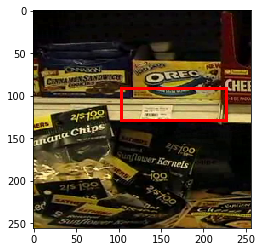

In [10]:
img = batch.data[0][3].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)
# draw bounding boxes on image
for label in batch.label[0][3].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()

### Aquí arranca la definición del Modelo, se definen un  número de cajas de diferentes tamaños y relaciones de aspecto

In [44]:
%matplotlib inline
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))  

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

The first anchor box at row 21, column 21: 
[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>


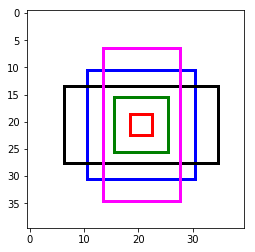

In [46]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), 
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [48]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

Class prediction (2, 55, 20, 20)


In [49]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

Box prediction (2, 40, 20, 20)


In [50]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


In [51]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [52]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)


Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [53]:
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32)]


In [54]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 10))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, use_global_stats=False, fix_gamma=False, momentum=0.9, eps=1e-05, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, use_global_stats=False, fix_gamma=False, momentum=0.9, eps=1e-05, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, use_global_stats=False, fix_gamma=False, momentum=0.9, eps=1e-05, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, use_global_stats=False, fix_gamma=False, momentum=0.9, eps=1e-05, in_channels=32)
    (5): Activati

In [55]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [56]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [57]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)


Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 3) box prediction (1, 21776)


In [58]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [59]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)


FocalLoss(batch_axis=0, w=None)


In [60]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [61]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

### En mxnet se puede configurar para entrenar con la gpu si hay alguna disponible. Con tensorflow creo que se hace automáticamente 

In [62]:
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

In [63]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [64]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

### Aquí arranca el entrenamiento. Pueden probar a configurar el número de épocas a alrededor de 100 para empezar. Yo las configuré a 20 porque sabía que no estaba leyendo las imágenes correctamente y sólo quería probar la ejecución

In [65]:
import time
from mxnet import autograd as ag

epochs = 10  # set larger to get better performance
log_interval = 20
start_epoch = 0

for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# we can save the trained parameters to disk
net.save_parameters('ssd_%d.params' % epochs)

[Epoch 0 Batch 19] speed: 211.217484 samples/s, training: accuracy=0.888753, mae=0.002745
[Epoch 0] training: accuracy=0.897523, mae=0.002807
[Epoch 0] time cost: 18.565040
[Epoch 1 Batch 19] speed: 224.374572 samples/s, training: accuracy=0.990388, mae=0.002583
[Epoch 1] training: accuracy=0.990571, mae=0.002626
[Epoch 1] time cost: 13.983156
[Epoch 2 Batch 19] speed: 223.410620 samples/s, training: accuracy=0.994705, mae=0.002670
[Epoch 2] training: accuracy=0.994831, mae=0.002615
[Epoch 2] time cost: 14.400800
[Epoch 3 Batch 19] speed: 183.571468 samples/s, training: accuracy=0.996582, mae=0.002557
[Epoch 3] training: accuracy=0.996610, mae=0.002563
[Epoch 3] time cost: 15.643700
[Epoch 4 Batch 19] speed: 210.257270 samples/s, training: accuracy=0.997232, mae=0.002459
[Epoch 4] training: accuracy=0.997259, mae=0.002422
[Epoch 4] time cost: 16.424221
[Epoch 5 Batch 19] speed: 173.416207 samples/s, training: accuracy=0.997393, mae=0.002538
[Epoch 5] training: accuracy=0.997441, mae=0.

### Aquí deben modificar el path para seleccionar una imagen cualquiera del dataset de validación a la que posteriormente se le aplicará el modelo de detección entrenado para ver qué tal funcionó

In [71]:
import numpy as np
import cv2

def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

image = cv2.imread('../../../../../DataSetGrozi120/val/00003.png')
x = preprocess(image)
print('x', x.shape)

x (1, 3, 256, 256)


In [72]:
# if pre-trained model is provided, we can load it
# net.load_parameters('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.15162501  0.15162501]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ..., 
  [ 0.01949999  0.01949999  0.98049998  0.98049998]
  [-0.12225395  0.18887302  1.12225389  0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.12225389]]]
<NDArray 1x5444x4 @gpu(0)>
class predictions 
[[[ 3.06567001 -0.34909281  0.39487323 ..., -0.62064654 -1.18924129
   -0.10275771]
  [ 2.37370563 -0.74574947 -0.66613346 ..., -0.96012902 -0.05801241
   -1.74337649]
  [ 3.49068809 -0.04208756 -0.12740625 ...,  0.40965149 -0.31609613
    1.06440389]
  ..., 
  [-0.34149486  1.28060687  0.88638806 ...,  0.06903679  0.17428721
   -0.57555884]
  [ 1.40241706 -0.88679308 -0.27253619 ..., -0.079753   -1.22819304
    0.76643771]
  [-0.77326387  0.46808156 -0.03824801 ..., -0.08636256 -0.30236375
    0.43803591]]]
<NDArray 1x5444x11 @gpu(0)>
box delta predictions 
[[ 0.71660519 -0.17589064  0.2671994  ..., -0.37797222 -0.

In [73]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 4.          0.27496454  0.20112467 -0.15275967  0.79797578  1.05868173]
  [ 4.          0.25316292  0.1219376   0.09227663  0.9989419   0.85743934]
  [ 4.          0.24502023  0.51228011  0.54393822  1.21662533  1.28876829]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x5444x6 @gpu(0)>


### Aquí se revisa la imagen que seleccionaro arribapara ver qué tal fueron las predicciones. La variable thres define el umbral de probabilidad mínimo para mostrar las predicciones

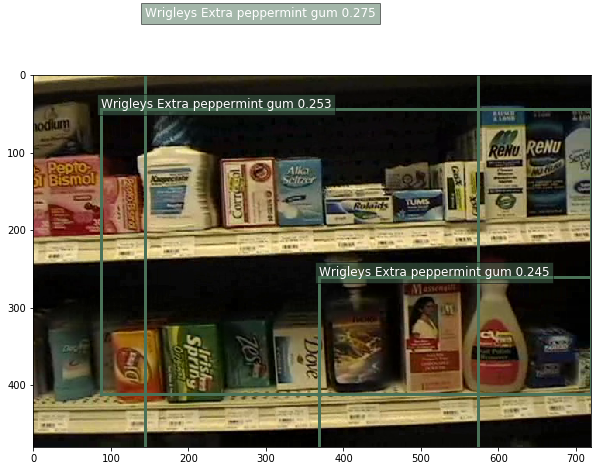

In [77]:
def display(img, out, thresh=0.2):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.2)

### Y hasta aquí llegué, sólo tengo por ahora una forma de evaluar el modelo visualmente pero la idea es aplicárselo a todo el conjunto de validación y encontrarle las métricas de evaluación